In [ ]:
#pip install lightfm

In [ ]:
#pip install transliterate

In [1]:
from copy import deepcopy
from itertools import combinations
import pickle
import typing as tp
from zipfile import ZipFile

from lightfm import LightFM
from lightfm.data import Dataset as LFMDataset
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from sklearn.preprocessing import normalize
from transliterate import translit

In [2]:
PATH_TO_DATA = "data_kion.zip"
RANDOM_STATE = 42

## Загрузка данных

Для целей семинара используем анонимизированные данные по просмотрам в онлайн-кинотеатре Кион. Мы имеем данные по действиям примерно за полгода, а также признаки пользователей и контента.

In [3]:
with ZipFile(PATH_TO_DATA) as zf:

    with zf.open("interactions.csv") as f:
        interactions = pd.read_csv(f)
    
    with zf.open("items.csv") as f:
        items = pd.read_csv(f)
    

Определим последний доступный день в выборке как тестовый, а 3 месяца до него - обучающей выборкой.

Для простоты:
- удачным взаимодействием будем считать просмотр любой длительности и при обучении будем использовать только эту информацию, игнорируя данные о признаках пользователей и контента
- не будем обрабатывать "холодных" пользователей, просто удалим их из тестовой выборки

In [4]:
train = interactions.loc[
    (interactions["last_watch_dt"] >= "2021-05-21")
    & (interactions["last_watch_dt"] <= "2021-08-21"),
    ["user_id", "item_id"]
]

test = interactions.loc[interactions["last_watch_dt"] == "2021-08-22", ["user_id", "item_id"]]
test = test.loc[test["user_id"].isin(train["user_id"]) & test["item_id"].isin(train["item_id"])]

In [5]:
train = pd.merge(train, items[["item_id", "title", "genres"]], on="item_id")
test = pd.merge(test, items[["item_id", "title", "genres"]], on="item_id")

## Добавление аватаров в обучающую выборку

Далее для построения рекомендаций будем использовать алгоритм матричного разложения из библиотеки LightFM. Для формирования рекомендаций для аватаров необходимо, чтобы действия аватаров были в обучающей выборке.

Отметим, что добавляя действия аватаров в обучающую выборку, мы несколько изменяем ее распределение. Обычно этим можно пренебречь, т.к. объем обучающей выборки (в нашем случае 5 млн наблюдений) значительно больше объема действий аватаров (10 наблюдений).

In [6]:
titles = [
    "Джон Уик", 
    "Заложница", 
    "Перевозчик",
    "Форсаж: Хоббс и Шоу",
    "Терминатор 3: Восстание машин"
]
avatar_interactions_action = pd.DataFrame({"user_id": "avatar_action", "title": titles})
avatar_interactions_action = avatar_interactions_action.merge(items[["item_id", "title", "genres"]], on="title")
avatar_interactions_action

,user_id,title,item_id,genres
0,avatar_action,Джон Уик,7671,"боевики, триллеры"
1,avatar_action,Заложница,14362,"боевики, триллеры"
2,avatar_action,Перевозчик,8350,"боевики, триллеры, криминал"
3,avatar_action,Форсаж: Хоббс и Шоу,2323,"боевики, триллеры"
4,avatar_action,Терминатор 3: Восстание машин,2925,"боевики, фантастика, триллеры"


In [7]:
titles = [
    "Тупой и еще тупее 2",
    "Типа крутые легавые",
    "Голый пистолет",
    "Убойные каникулы",
    "Карты, деньги, два ствола"
]
avatar_interactions_comedy = pd.DataFrame({"user_id": "avatar_comedy", "title": titles})
avatar_interactions_comedy = avatar_interactions_comedy.merge(items[["item_id", "title", "genres"]], on="title")
avatar_interactions_comedy

,user_id,title,item_id,genres
0,avatar_comedy,Тупой и еще тупее 2,8391,комедии
1,avatar_comedy,Типа крутые легавые,2915,"боевики, триллеры, детективы, комедии"
2,avatar_comedy,Голый пистолет,1734,комедии
3,avatar_comedy,Убойные каникулы,4979,"ужасы, комедии"
4,avatar_comedy,"Карты, деньги, два ствола",2866,комедии


In [8]:
train = pd.concat([train, avatar_interactions_action, avatar_interactions_comedy], sort=False)

## Обучение модели

In [9]:
%%time

lfm_dataset = LFMDataset()
lfm_dataset.fit(
    users=train["user_id"].values,
    items=train["item_id"].values,
)

train_matrix, _ = lfm_dataset.build_interactions(zip(*train[["user_id", "item_id"]].values.T))

CPU times: user 13.7 s, sys: 438 ms, total: 14.2 s
Wall time: 14.2 s


In [10]:
%%time

lfm_model = LightFM(
    learning_rate=0.01, 
    loss='warp', 
    no_components=64,
    random_state=RANDOM_STATE
)
lfm_model.fit(
    interactions=train_matrix, 
    epochs=20,
    num_threads=20,
);

CPU times: user 13min 34s, sys: 2.34 s, total: 13min 36s
Wall time: 56.1 s


## Рекомендации для аватаров

In [11]:
n_recommendations = 10

In [12]:
id_item_mapping = {v: k for k, v in lfm_dataset._item_id_mapping.items()}

In [13]:
def get_n_recommendations_for_user(
    user_id: str,
    model: LightFM,
    train_matrix: coo_matrix,
    user_to_id: tp.Dict[str, int],
    id_to_item: tp.Dict[int, str],
    n_recommendations: int
) -> pd.DataFrame:
    user_inner_id = user_to_id[user_id]
    scores = model.predict(
        user_ids=user_inner_id,
        item_ids=np.arange(train_matrix.shape[1]),
        num_threads=20
    )
    user_watched_items = train_matrix.col[train_matrix.row == user_inner_id]
    scores[user_watched_items] = -np.inf

    recommended_item_inner_ids = np.argpartition(scores, -np.arange(n_recommendations))[
        -n_recommendations:
    ][::-1]
    recommended_item_ids = [id_to_item[x] for x in recommended_item_inner_ids]
    return recommended_item_ids


In [14]:
user_id = "avatar_action"

recommended_items = get_n_recommendations_for_user(
    user_id=user_id,
    model=lfm_model,
    train_matrix=train_matrix,
    user_to_id=lfm_dataset._user_id_mapping,
    id_to_item=id_item_mapping,
    n_recommendations=n_recommendations
)
pd.DataFrame({"user_id": user_id, "item_id": recommended_items}).merge(items[["item_id", "title", "genres"]])

,user_id,item_id,title,genres
0,avatar_action,9728,Гнев человеческий,"боевики, триллеры"
1,avatar_action,12173,Мстители: Финал,"боевики, драмы, фантастика"
2,avatar_action,7626,Мстители: Война бесконечности,"боевики, фантастика, приключения"
3,avatar_action,14317,Веном,"популярное, фантастика, триллеры, боевики, ужасы"
4,avatar_action,13865,Девятаев,"драмы, военные, приключения"
5,avatar_action,10942,Мстители,"боевики, фантастика, фэнтези, приключения"
6,avatar_action,5693,Алита: Боевой ангел,"боевики, фантастика, триллеры, приключения"
7,avatar_action,10440,Хрустальный,"триллеры, детективы"
8,avatar_action,1287,Терминатор: Тёмные судьбы,"боевики, фантастика, приключения"
9,avatar_action,1785,Чёрная пантера,"боевики, фантастика, приключения"


In [15]:
user_id = "avatar_comedy"

recommended_items = get_n_recommendations_for_user(
    user_id=user_id,
    model=lfm_model,
    train_matrix=train_matrix,
    user_to_id=lfm_dataset._user_id_mapping,
    id_to_item=id_item_mapping,
    n_recommendations=n_recommendations
)
pd.DataFrame({"user_id": user_id, "item_id": recommended_items}).merge(items[["item_id", "title", "genres"]])

,user_id,item_id,title,genres
0,avatar_comedy,9728,Гнев человеческий,"боевики, триллеры"
1,avatar_comedy,10440,Хрустальный,"триллеры, детективы"
2,avatar_comedy,13865,Девятаев,"драмы, военные, приключения"
3,avatar_comedy,15297,Клиника счастья,"драмы, мелодрамы"
4,avatar_comedy,3734,Прабабушка легкого поведения,комедии
5,avatar_comedy,2657,Подслушано,"драмы, триллеры"
6,avatar_comedy,7793,Радиовспышка,"боевики, драмы, фантастика, триллеры"
7,avatar_comedy,7571,100% волк,"мультфильм, приключения, семейное, фэнтези, ко..."
8,avatar_comedy,4740,Сахаров. Две жизни,документальное
9,avatar_comedy,14317,Веном,"популярное, фантастика, триллеры, боевики, ужасы"


In [16]:
# самые просматриваемые в обучающей выборке
train["title"].value_counts().head(10)

Хрустальный                     189530
Клиника счастья                 189262
Гнев человеческий               130520
Девятаев                        125905
Прабабушка легкого поведения     74037
Подслушано                       68194
Секреты семейной жизни           66084
Фемида видит                     37020
Афера                            36193
Сахаров. Две жизни               33980
Name: title, dtype: int64

Мы получили, что рекомендации для аватаров имеют сильное пересечение, обусловленное перекосом к рекомендациям популярного контента.

##  Попробуем побороться с перекосом к популярным

Алгоритм обучает для каждого пользователя $u$ и товара $i$ соответственно смещения $b_u$, $b_i$ и эмбеддинги $p_u$, $q_i$. Для формирования рекомендаций для пользователя выбираются товары, имеющие наибольшие значения скоров, определяющихся по формуле:

$$score_{ui} = b_u + b_i + p_u \cdot q_i = b_u + b_i + \cos ( p_u, q_i ) \cdot || p_u || \cdot || q_i || .$$

Часто перекос к популярным выражается в больших значениях смещений или норм эмбеддингов у популярных товаров. В таких случаях может помочь переход от ранжирования по значениям скалярных произведений к ранжированию по косинусам угла между эмбеддингами пользователей и товаров.

Для перехода к косинусам согласно формуле выше достаточно заменить $b_u$ и $b_i$ нулями и привести нормы $p_u$ и $q_i$ к единицам.

In [17]:
lfm_model_cos = deepcopy(lfm_model)

lfm_model_cos.item_biases = np.zeros_like(lfm_model_cos.item_biases)
lfm_model_cos.user_biases = np.zeros_like(lfm_model_cos.user_biases)

lfm_model_cos.item_embeddings = normalize(lfm_model_cos.item_embeddings)
lfm_model_cos.user_embeddings = normalize(lfm_model_cos.user_embeddings)

In [18]:
user_id = "avatar_action"

recommended_items = get_n_recommendations_for_user(
    user_id=user_id,
    model=lfm_model_cos,
    train_matrix=train_matrix,
    user_to_id=lfm_dataset._user_id_mapping,
    id_to_item=id_item_mapping,
    n_recommendations=n_recommendations
)
pd.DataFrame({"user_id": user_id, "item_id": recommended_items}).merge(items[["item_id", "title", "genres"]])

,user_id,item_id,title,genres
0,avatar_action,8579,Библиотекарь 3: Проклятие иудовой чаши,"приключения, триллеры, мелодрамы, боевики, фэн..."
1,avatar_action,4927,День независимости: Возрождение,"боевики, фантастика, приключения"
2,avatar_action,3404,РЭД,"боевики, триллеры, криминал, комедии"
3,avatar_action,16438,Скайлайн,"боевики, фантастика, триллеры"
4,avatar_action,6541,Пуленепробиваемый монах,"боевики, мелодрамы, фэнтези, комедии"
5,avatar_action,4754,Геракл: Начало легенды,"боевики, фэнтези"
6,avatar_action,7914,Король Артур,"боевики, драмы"
7,avatar_action,2590,Другой мир 2: Эволюция,"боевики, фэнтези, триллеры"
8,avatar_action,14775,Район №9,"боевики, фантастика, триллеры"
9,avatar_action,13937,Макс Стил,"приключения, фантастика, боевики, семейное, фэ..."


In [19]:
user_id = "avatar_comedy"

recommended_items = get_n_recommendations_for_user(
    user_id=user_id,
    model=lfm_model_cos,
    train_matrix=train_matrix,
    user_to_id=lfm_dataset._user_id_mapping,
    id_to_item=id_item_mapping,
    n_recommendations=n_recommendations
)
pd.DataFrame({"user_id": user_id, "item_id": recommended_items}).merge(items[["item_id", "title", "genres"]])

,user_id,item_id,title,genres
0,avatar_comedy,460,Счастливчик Гилмор,комедии
1,avatar_comedy,3401,Зомби по имени Шон,"ужасы, комедии"
2,avatar_comedy,12869,Доспехи Бога 3: Миссия Зодиак,"боевики, приключения, комедии"
3,avatar_comedy,4432,Затура: Космическое приключение,"приключения, фантастика, боевики, семейное, фэ..."
4,avatar_comedy,834,Хоттабыч,"фантастика, приключения, комедии"
5,avatar_comedy,14006,Царь Скорпионов: Книга Душ,"боевики, фэнтези, приключения"
6,avatar_comedy,5311,Очень голодные игры,"фантастика, комедии"
7,avatar_comedy,3189,Параллельные миры,"фэнтези, мелодрамы"
8,avatar_comedy,3682,Атака титанов. Фильм первый: Жестокий мир,"боевики, драмы, фантастика, аниме"
9,avatar_comedy,13544,Короткое замыкание,"фантастика, семейное, комедии"


Видно, что рекомендации стали более персонализированными для аватаров и исчезло преобладание популярного контента. Однако говорить о том, что новая версия модели лучше рано. Выводы стоит делать после того, как будут в том числе проведены количественные оценки качества (оффлайн и онлайн метрики).

## Похожие фильмы

In [20]:
from scipy.spatial.distance import cdist


def get_n_similar_movies(
    item_id: str,
    model: LightFM,
    item_to_id: tp.Dict[str, int],
    id_to_item: tp.Dict[int, str],
    n_recommendations: int
) -> pd.DataFrame:
    item_inner_id = item_to_id[item_id]
    _, embeddings = model.get_item_representations()
    
    similarities = 1 - cdist(embeddings[item_inner_id].reshape(1, -1), embeddings, metric="cosine")
    similarities = similarities[0]
    similarities[item_inner_id] = -np.inf
    
    similar_movie_inner_ids = np.argsort(-similarities)[:10]
    similar_movie_ids = [id_to_item[x] for x in similar_movie_inner_ids]
    return similar_movie_ids

In [21]:
item_id = 7671  # Джон Уик

similar_movies = get_n_similar_movies(
    item_id=item_id,
    model=lfm_model_cos,
    item_to_id=lfm_dataset._item_id_mapping,
    id_to_item=id_item_mapping,
    n_recommendations=n_recommendations
)
pd.DataFrame({"item_id": similar_movies}).merge(items[["item_id", "title", "genres"]])

,item_id,title,genres
0,5482,Неудержимый,"боевики, триллеры, криминал"
1,15064,Лучшие из лучших 2,"боевики, драмы, триллеры, криминал"
2,78,Стелс,"боевики, фантастика, триллеры, приключения"
3,12302,Проповедник с пулемётом,"боевики, драмы"
4,8694,Чужие против Хищника: Реквием,"боевики, ужасы, фантастика, триллеры"
5,12546,Патриот,"боевики, драмы, историческое, военные"
6,10227,Успеть за 30 минут,боевики
7,4062,Мачете убивает,"боевики, комедии"
8,10786,Крепкий орешек 4.0,"боевики, триллеры"
9,483,Исход: Цари и боги,"боевики, драмы, фэнтези, приключения"


In [22]:
item_id = 2323  # Форсаж: Хоббс и Шоу

similar_movies = get_n_similar_movies(
    item_id=item_id,
    model=lfm_model,
    item_to_id=lfm_dataset._item_id_mapping,
    id_to_item=id_item_mapping,
    n_recommendations=n_recommendations
)
pd.DataFrame({"item_id": similar_movies}).merge(items[["item_id", "title", "genres"]])

,item_id,title,genres
0,28,Хоббит: Нежданное путешествие,"зарубежные, семейное, фэнтези, приключения"
1,10508,Хоббит: Битва пяти воинств,"зарубежные, фэнтези, приключения"
2,1735,Форсаж 8,"боевики, триллеры, криминал"
3,6547,Хоббит: Пустошь Смауга,"зарубежные, фэнтези, приключения"
4,16382,Человек-паук,"боевики, фантастика, приключения"
5,3166,Человек-паук 2,"боевики, фантастика, приключения"
6,14567,Новый Человек-паук,"боевики, фантастика, приключения"
7,4072,Человек-паук 3: Враг в отражении,"боевики, фантастика, приключения"
8,12299,Новый Человек-паук: Высокое напряжение,"боевики, фантастика, приключения"
9,7594,[4k] Трансформеры,"приключения, зарубежные, фантастика, боевики, ..."


## Расчет рекомендаций

Сформируем таблицы рекомендаций для пользователей из тестовой выборки.

Далее с помощью этих таблиц будут оценены метрики beyond accuracy. Методологически вернее оценивать данные метрики на всей пользовательской базе, а не только для пользователей, имеющих действия в тестовой выборке. Здесь мы этим пренебрежем для экономии вычислительных ресурсов.

In [23]:
models_dict = {"lfm": lfm_model, "lfm_cos": lfm_model_cos}

In [24]:
%%time

recommendations_dict = {}
for model_name, model in models_dict.items():
    recommendations = pd.DataFrame({"user_id": test["user_id"].unique()})
    recommendations["item_id"] = recommendations["user_id"].apply(
        get_n_recommendations_for_user,
        args=(
            model,
            train_matrix,
            lfm_dataset._user_id_mapping,
            id_item_mapping,
            n_recommendations
        ),
    )
    recommendations = recommendations.explode("item_id")
    recommendations["rank"] = recommendations.groupby(["user_id"]).cumcount() + 1
    recommendations_dict[model_name] = recommendations
    

CPU times: user 1h 4min 15s, sys: 12.2 s, total: 1h 4min 28s
Wall time: 3min 13s


# Оценка метрик классификации

Эти метрики оценивают качество топ-N рекомендаций. В рекомендательные системы напрямую перекочевали из методов оценки качества бинарной классификации.
Все считается на основе 4 базовых случаев:
* True positive  (TP) - модель рекомендовала объект, с которым пользователь провзаимодействовал
* False positive (FP) - модель рекомендовала объект, с которым пользователь не провзаимодействовал
* True negative  (TN) - модель не рекомендовала объект, с которым пользователь не провзаимодействовал
* False negative (FN) - модель не рекомендовала объект, с которым пользователь провзаимодействовал

Что из этого всего важней? В первую очередь это True positive. Мы хотим строить наиболее релевантные рекомендации для пользователя. 
Во вторую очередь это False negative, опять же потому, что мы не хотим, чтобы модель "теряла" релевантные рекомендации.

А что с FP и TN? На самом деле, эти величины не показательны. Они обычно очень больше, так как пользователи взаимодействуют с очень малым количество объектов относительно общего числа объектов.
И практика показывает, что этими значениями можно пренебречь.

Для измерения доли TP и FN применяются следующие метрики:
* **Precision@K** - доля релевантных рекомендаций среди всех рекомендаций
    * Формула - `TP / (TP + FP)`
    * Можно заметить, что под positives мы понимаем рекомендованные объекты, то есть наш топ-К, значит `TP + FP = K`
    * Итоговая формула - `TP / K`
    * Считаем по каждому пользователю и для некторых К
    * Усредняем по всем пользователя
* **Recall@K** - доля релевантных рекомендаций среди всех релевантных объектов
    * Формула - `TP / (TP + FN)`
    * `TP + FN` это количество известных релевантых объектов для пользователя
    * Считаем по каждому пользователю и для некторых К
    * Усредняем по всем пользователя

In [25]:
df_true = pd.DataFrame({
    'user_id': ['Аня',                'Боря',               'Вася',         'Вася'],
    'item_id': ['Джентельмены удачи', '451° по Фаренгейту', 'Зеленая миля', 'Побег из Шоушенка'],
})
df_true

,user_id,item_id
0,Аня,Джентельмены удачи
1,Боря,451° по Фаренгейту
2,Вася,Зеленая миля
3,Вася,Побег из Шоушенка


In [26]:
df_recs = pd.DataFrame({
    'user_id': [
        'Аня', 'Аня', 'Аня', 
        'Боря', 'Боря', 'Боря', 
        'Вася', 'Вася', 'Вася',
    ],
    'item_id': [
        'Служебный роман', 'Бриллиантовая рука', '12 стульев', 
        '451° по Фаренгейту', '1984', 'Бегущий по лезвию',
        'Оно', 'Сияние', 'Зеленая миля', 
    ],
    'rank': [
        1, 2, 3,
        1, 2, 3,
        1, 2, 3,
    ]
})
df_recs

,user_id,item_id,rank
0,Аня,Служебный роман,1
1,Аня,Бриллиантовая рука,2
2,Аня,12 стульев,3
3,Боря,451° по Фаренгейту,1
4,Боря,1984,2
5,Боря,Бегущий по лезвию,3
6,Вася,Оно,1
7,Вася,Сияние,2
8,Вася,Зеленая миля,3


In [27]:
df_merged = df_true.set_index(['user_id', 'item_id']).join(df_recs.set_index(['user_id', 'item_id']), how='left')
df_merged

rank
user_id item_id                 
Аня     Джентельмены удачи   NaN
Боря    451° по Фаренгейту   1.0
Вася    Зеленая миля         3.0
        Побег из Шоушенка    NaN

Вначале посчитаем метрик для топ-2 (т.е. К = 2). Алгоритм следующий:
* Релевантные объекты, которые не были рекомендованы игнорируем (NaN)
* Определяем, какие релеватные рекомендации попали в топ-2 (hit)
    * True positive для каждого пользователя
* Делим TP на K  
* Считаем Precision@K для каждого пользователя как сумму его TP/K
* Все Precision@K усредняем

In [28]:
df_merged['hit@2'] = df_merged['rank'] <= 2
df_merged

rank  hit@2
user_id item_id                        
Аня     Джентельмены удачи   NaN  False
Боря    451° по Фаренгейту   1.0   True
Вася    Зеленая миля         3.0  False
        Побег из Шоушенка    NaN  False

In [29]:
df_merged['hit@2/2'] = df_merged['hit@2'] / 2
df_merged

rank  hit@2  hit@2/2
user_id item_id                                 
Аня     Джентельмены удачи   NaN  False      0.0
Боря    451° по Фаренгейту   1.0   True      0.5
Вася    Зеленая миля         3.0  False      0.0
        Побег из Шоушенка    NaN  False      0.0

In [30]:
df_prec2 = df_merged.groupby(level=0)['hit@2/2'].sum()
df_prec2

user_id
Аня     0.0
Боря    0.5
Вася    0.0
Name: hit@2/2, dtype: float64

In [31]:
print(f'Precision@2 - {df_prec2.mean()}')

Precision@2 - 0.16666666666666666


In [32]:
users_count = df_merged.index.get_level_values('user_id').nunique()
for k in [1, 2, 3]:
    hit_k = f'hit@{k}'
    df_merged[hit_k] = df_merged['rank'] <= k
    print(f'Precision@{k} = {(df_merged[hit_k] / k).sum() / users_count:.4f}')

Precision@1 = 0.3333
Precision@2 = 0.1667
Precision@3 = 0.2222


C Recall@K похожая история, нам также нужно получить hit@K, но делить уже будем на количество релевантных объектов у пользователя

In [33]:
df_merged['users_item_count'] = df_merged.groupby(level='user_id')['rank'].transform(np.size)
df_merged

rank  hit@2  hit@2/2  hit@1  hit@3  \
user_id item_id                                                  
Аня     Джентельмены удачи   NaN  False      0.0  False  False   
Боря    451° по Фаренгейту   1.0   True      0.5   True   True   
Вася    Зеленая миля         3.0  False      0.0  False   True   
        Побег из Шоушенка    NaN  False      0.0  False  False   

                            users_item_count  
user_id item_id                               
Аня     Джентельмены удачи               1.0  
Боря    451° по Фаренгейту               1.0  
Вася    Зеленая миля                     2.0  
        Побег из Шоушенка                2.0

In [34]:
for k in [1, 2, 3]:
    hit_k = f'hit@{k}'
    # Уже посчитано
    # df_merged[hit_k] = df_merged['rank'] <= k  
    print(f"Recall@{k} = {(df_merged[hit_k] / df_merged['users_item_count']).sum() / users_count:.4f}")

Recall@1 = 0.3333
Recall@2 = 0.3333
Recall@3 = 0.5000


Precision@K и Recall@K неплохие метрики, чтобы оценить качество рекомендаций, но они учитывают только "попадания" (hits, true positives). 
Но на самом деле нам важно насколько высоко по позициям находятся эти самые попадания. 

Простой пример, пусть две модели рекомендаций для одного пользователя получили такие hit@4 на тесте:
* model1 - 1, 0, 0, 1
* model2 - 1, 0, 1, 0

Precision@4 для них будет одинаковый - 0.5, хотя model2 немного лучше, так как 2-ое попадание находится выше, чем у model1

# Оценка метрик ранжирования

Эти метрики оценивают качество топ-N рекомендаций c учетом рангов/позиций. Основная идея - оценить "попадания" с весом, зависящим от позиции (обычно это обратная пропорциальная зависимость, то есть чем больше позиция, тем меньше вес).
Основные метрики следующие:

**Mean Reciprocal Rank**

<div>
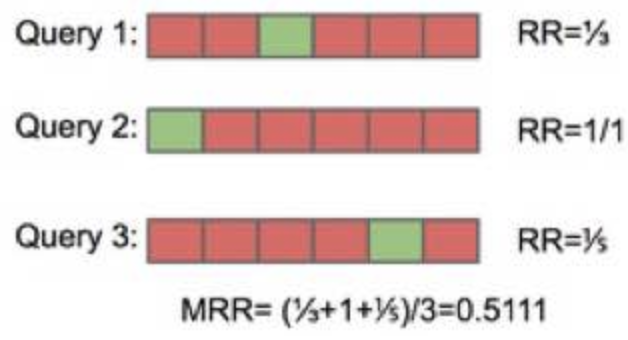
</div>

$$ MRR = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{rank_i}, $$

где $N$ - количество пользователей, а $rank_i$ - позиция первой релевантной рекомендации

**Mean Average Precision**

$$ MAP@k = \frac{1}{N} \sum_{i=1}^{N} AP@k(user_i) $$

$$ AP@k = \frac{1}{c_{user}} \sum_{i=1}^{k} Precision@i * rel_i $$

То есть MAP - это усреднение AveragePrecision по всем пользователям. 
А AveragePrecision в свою очередь, это средний Precision@K по релевантным объектам одного пользователя.

In [35]:
df_merged = df_true.set_index(['user_id', 'item_id']).join(df_recs.set_index(['user_id', 'item_id']), how='left')
df_merged = df_merged.sort_values(by=['user_id', 'rank'])
df_merged

rank
user_id item_id                 
Аня     Джентельмены удачи   NaN
Боря    451° по Фаренгейту   1.0
Вася    Зеленая миля         3.0
        Побег из Шоушенка    NaN

In [36]:
df_merged['reciprocal_rank'] = 1 / df_merged['rank']
df_merged

rank  reciprocal_rank
user_id item_id                                  
Аня     Джентельмены удачи   NaN              NaN
Боря    451° по Фаренгейту   1.0         1.000000
Вася    Зеленая миля         3.0         0.333333
        Побег из Шоушенка    NaN              NaN

In [37]:
mrr = df_merged.groupby(level='user_id')['reciprocal_rank'].max()
mrr

user_id
Аня          NaN
Боря    1.000000
Вася    0.333333
Name: reciprocal_rank, dtype: float64

In [38]:
print(f"MRR = {mrr.fillna(0).mean()}")

MRR = 0.4444444444444444


In [53]:
df_merged['cumulative_rank'] = df_merged.groupby(level='user_id').cumcount() + 1
df_merged['cumulative_rank'] = df_merged['cumulative_rank'] / df_merged['rank']
df_merged['users_item_count'] = df_merged.groupby(level='user_id')['rank'].transform(np.size)
df_merged

rank  reciprocal_rank  cumulative_rank  \
user_id item_id                                                      
Аня     Джентельмены удачи   NaN              NaN              NaN   
Боря    451° по Фаренгейту   1.0         1.000000         1.000000   
Вася    Зеленая миля         3.0         0.333333         0.333333   
        Побег из Шоушенка    NaN              NaN              NaN   

                            users_item_count  
user_id item_id                               
Аня     Джентельмены удачи               1.0  
Боря    451° по Фаренгейту               1.0  
Вася    Зеленая миля                     2.0  
        Побег из Шоушенка                2.0

In [51]:
users_count = df_merged.index.get_level_values('user_id').nunique()
map3 = (df_merged["cumulative_rank"] / df_merged["users_item_count"]).sum() / users_count
print(f"MAP@3 = {map3}")

MAP@3 = 0.3888888888888889


## Оценка метрик на тестовом датасете

In [41]:
def compute_metrics(df_true, df_pred, top_N):
    result = {}
    test_recs = df_true.set_index(['user_id', 'item_id']).join(df_pred.set_index(['user_id', 'item_id']))
    test_recs = test_recs.sort_values(by=['user_id', 'rank'])

    test_recs['users_item_count'] = test_recs.groupby(level='user_id')['rank'].transform(np.size)
    test_recs['reciprocal_rank'] = (1 / test_recs['rank']).fillna(0)
    test_recs['cumulative_rank'] = test_recs.groupby(level='user_id').cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs['rank']
    
    users_count = test_recs.index.get_level_values('user_id').nunique()
    for k in range(1, top_N + 1):
        hit_k = f'hit@{k}'
        test_recs[hit_k] = test_recs['rank'] <= k
        result[f'Precision@{k}'] = (test_recs[hit_k] / k).sum() / users_count
        result[f'Recall@{k}'] = (test_recs[hit_k] / test_recs['users_item_count']).sum() / users_count

    result[f'MAP@{top_N}'] = (test_recs["cumulative_rank"] / test_recs["users_item_count"]).sum() / users_count
    result[f'MRR'] = test_recs.groupby(level='user_id')['reciprocal_rank'].max().mean()
    return pd.Series(result)

In [42]:
compute_metrics(test, recommendations_dict["lfm"], 10)

Precision@1     0.057668
Recall@1        0.041889
Precision@2     0.047573
Recall@2        0.068134
Precision@3     0.042701
Recall@3        0.090443
Precision@4     0.038249
Recall@4        0.107408
Precision@5     0.034974
Recall@5        0.122454
Precision@6     0.032265
Recall@6        0.134846
Precision@7     0.030008
Recall@7        0.145387
Precision@8     0.028185
Recall@8        0.155551
Precision@9     0.026560
Recall@9        0.164128
Precision@10    0.024955
Recall@10       0.170781
MAP@10          0.077647
MRR             0.103597
dtype: float64

In [43]:
compute_metrics(test, recommendations_dict["lfm_cos"], 10)

Precision@1     0.006995
Recall@1        0.004591
Precision@2     0.006460
Recall@2        0.008207
Precision@3     0.005926
Recall@3        0.011069
Precision@4     0.005613
Recall@4        0.014056
Precision@5     0.005278
Recall@5        0.016373
Precision@6     0.005106
Recall@6        0.018890
Precision@7     0.004835
Recall@7        0.020634
Precision@8     0.004631
Recall@8        0.022451
Precision@9     0.004446
Recall@9        0.024241
Precision@10    0.004395
Recall@10       0.026602
MAP@10          0.010050
MRR             0.015303
dtype: float64

Из значений метрик видно, что модель со скосом к популярному имеет бОльшие значения метрик, это логично, тк популярные фильмы, просматриваемые пользователями в обучающем периоде, обычно популярны и в течение тестового периода. Здесь стоит отметить, что в тч из-за этого наблюдения выбор модели для раскатки на реальных пользователях, основанный на значениях оффлайн метрик, в рекомендациях обычно не оправдан. Например, в описанном случае совсем необязательно пользователям больше понравятся рекомендации популярного контента относительно более персонализированного. Честным способом сравнения моделей рекомендаций является проведение АБ-теста, в рамках которого для разных алгоритмов будут сравниваться бизнес-метрики (в случае онлайн-кинотеатра это могут быть метрики метрики среднего времени просмотра контента за тестовый период, среднее количество просмотренных тайтлов и тд). 

<div>
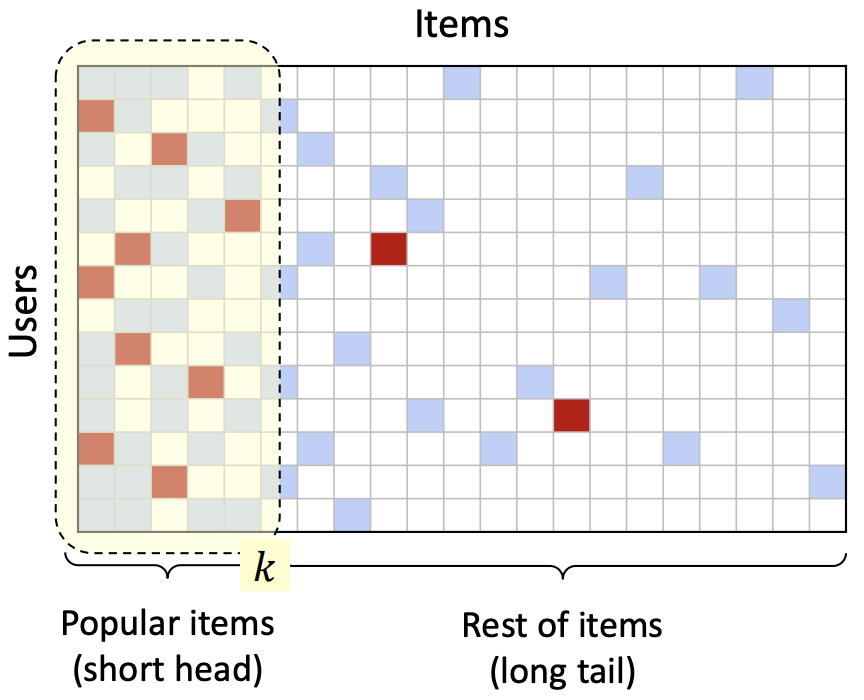
</div>

<div>
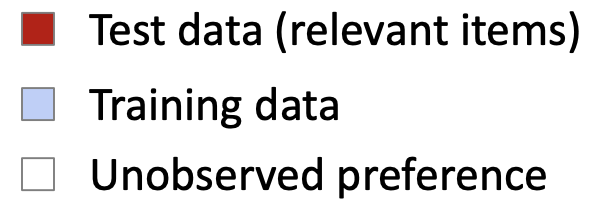
</div>

# Оценка beyond accuracy метрик
## Intra-List Diversity

Оценим для обеих моделей среднее разнообразие контента в полках с помощью метрики $ILD$:

$$ ILD = \frac{1}{|R| ( |R| - 1 )} \sum_{i \in R} \sum_{j \in R} d(i, j) . $$

В качестве расстояния $d(i, j)$ используем [расстояние Хэмминга](https://neerc.ifmo.ru/wiki/index.php?title=Расстояние_Хэмминга) между one-hot векторами жанров. Пример расчета:

##### <center>d(10<font color='blue'>1</font>1<font color='blue'>1</font>01, 10<font color='red'>0</font>1<font color='red'>0</font>01) = 2.</center>



Для оценки расстояния Хэмминга между фильмами вытянем список жанров в one-hot векторы.

In [44]:
items[["item_id", "genres"]].head()

,item_id,genres
0,10711,"драмы, зарубежные, детективы, мелодрамы"
1,8250,"зарубежные, триллеры"
2,2508,"зарубежные, приключения, комедии"
3,10716,"криминал, зарубежные, триллеры, боевики, комедии"
4,7868,"драмы, зарубежные, мелодрамы"


In [45]:
item_genres_one_hot = items[["item_id", "genres"]].copy()
item_genres_one_hot["genres"] = item_genres_one_hot["genres"].str.split(", ")
item_genres_one_hot = item_genres_one_hot.explode("genres")
item_genres_one_hot["genres"] = item_genres_one_hot["genres"].str.replace(" ", "_")
item_genres_one_hot["genres"] = item_genres_one_hot["genres"].map(lambda x: translit(x, "ru", reversed=True))
item_genres_one_hot["value"] = 1
item_genres_one_hot = item_genres_one_hot.pivot(
    index="item_id", 
    columns="genres", 
    values="value"
).fillna(0).astype(int)

item_genres_one_hot.head()

genres,18+,animatsija,anime,arthaus,biografija,bloger,boeviki,detektivy,detskie,detskie_pesni,...,trillery,uvlechenija,uzhasy,vestern,voennye,vokrug_sveta,vospitanie_detej,zapadnye_mul'tfil'my,zarubezhnye,zhivaja_priroda
item_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
def get_hamming_distances(pairs: pd.Series, features: pd.DataFrame) -> np.ndarray:
    items_0 = pairs.map(lambda pair: pair[1]).values
    items_1 = pairs.map(lambda pair: pair[0]).values

    features_0 = features.reindex(items_0).values
    features_1 = features.reindex(items_1).values
    return np.sum(features_0 != features_1, axis=1)


def calculate_intra_list_diversity_per_user(recommendations: pd.DataFrame, features: pd.DataFrame) -> pd.Series:
    recommended_item_pairs = recommendations.groupby("user_id")["item_id"].apply(
        lambda x: list(combinations(x, 2))
    ).reset_index().explode("item_id").rename(columns={"item_id": "item_pair"})
    recommended_item_pairs["dist"] = get_hamming_distances(recommended_item_pairs["item_pair"], features)
    return recommended_item_pairs[["user_id", "dist"]].groupby("user_id").agg("mean")


In [47]:
%%time

for model_name, recommendations in recommendations_dict.items():
    ild_per_user = calculate_intra_list_diversity_per_user(recommendations, item_genres_one_hot)
    print(f"model: {model_name}, mean ild: {round(float(ild_per_user.mean()), 2)}\n")
    

model: lfm, mean ild: 3.2

model: lfm_cos, mean ild: 3.01

CPU times: user 7.56 s, sys: 2.53 s, total: 10.1 s
Wall time: 10.1 s


Модель, тяготеющая к рекомендации популярного контента, отдает более разнообразные полки по набору жанров. Это логично, т.к. подборки популярного контента обычно разнообразны по значениям различных наборов признаков.

## Mean Inverse User Frequency

Оценим новизну рекомендаций. Новизна товара обратно пропорциональна количеству пользователей, которые с ним взаимодействовали в обучающей выборке. Значение метрики для полки определяется как средняя "новизна" товаров в полке.

$$ MIUF = -\frac{1}{|R|} \sum_{i \in R} \log_2 \frac{|U_i|}{|U|} $$

In [48]:
def calculate_mean_inv_user_frequency_per_user(recommendations: pd.DataFrame, train: pd.DataFrame) -> pd.Series:
    n_users = train["user_id"].nunique()
    n_users_per_item = train.groupby("item_id")["user_id"].nunique()
    
    recommendations_ = recommendations[["user_id", "item_id"]].copy()
    recommendations_["n_users_per_item"] = recommendations_["item_id"].map(n_users_per_item)
    recommendations_["inv_user_freq"] = -np.log2(recommendations_["n_users_per_item"] / n_users)
    return recommendations_[["user_id", "inv_user_freq"]].groupby("user_id").agg("mean")

In [49]:
for model_name, recommendations in recommendations_dict.items():
    miuf_per_user = calculate_mean_inv_user_frequency_per_user(recommendations, train)
    print(f"model: {model_name}, mean miuf: {round(float(miuf_per_user.mean()), 2)}\n")

model: lfm, mean miuf: 4.41

model: lfm_cos, mean miuf: 10.29



Естественно, модель, отдающая полки с популярным контентом, имеет значительно меньшее значение метрики, т.к. метрика принимает высокие значения в тех случаях, когда подборка состоит из контента в "длинном" хвосте.